In [1]:

import matplotlib.pyplot as plt
import gpflow
import gpflux
import numpy as np
import ruptures as rpt
import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer
from scipy.optimize import linear_sum_assignment
from ruptures.base import BaseCost
import random

C:\Users\motsk\anaconda3\envs\thesis\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Signal/Time Series Construction
## Poisson Point Process
We start by defining an intensity function for the Non-Homogeneous Poisson process (NHPP) and then generate a Point process using a thinning algorithm that can be found here (https://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-PP-NSPP.pdf)

In [2]:
def lam(x, a):
    """
    Intensity function for the NHPP
    """
    return a + np.sin(x)

In [3]:
def sample_poisson_jumps(a, lambda_star, length=1000, seed=None):
    """
    Thinning algorithm for generating a poisson point process signal.
    """
    if seed is not None:
        np.random.seed(seed)
    T = 0.01 * length
    t = 0.0
    n = 0
    arrival_times = []
    while True:
        u = np.random.rand()
        t = t - (1/lambda_star) * np.log(u)

        if t > T:
            break
        u = np.random.rand()
        lambda_t = lam(t, a)
        if u <= lambda_t / lambda_star:
            n += 1
            arrival_times.append(t)
    ts = np.linspace(0, T, length)
    ys = np.searchsorted(arrival_times, ts)
    return ts, ys, arrival_times, T

## Deep Gaussian Process (DGP)
We continue with defining the correlated noise of the signals. We start by defining a helper function for sampling layer kernels and hyperparameters. We choose to sample from four stationary kernels supported by GPFlow for each layer and vary their hyperparameters by sampling from the range [0.1, 5]. We then create a set of datapoints that are propagated through a number of predefined layers and save the output of the final layer.

In [4]:
KERNELS = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12,
          gpflow.kernels.Matern32,
          gpflow.kernels.Matern52]

In [5]:
def randomly_sample_kernels(kernels, num_kernels, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sampled_kernels = []
    for i in range(num_kernels):
        kernel = np.random.choice(kernels)()
        lengthscales = np.random.uniform(0.1, 5.0)
        variance = np.random.uniform(0.1, 5.0)
        kernel.lengthscales.assign(lengthscales)
        kernel.variance.assign(variance)
        sampled_kernels.append(kernel)
    return sampled_kernels

In [6]:
def sample_dgp_signal(datapoints, a, b, samples, kernels, num_layers, seed=None):
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)
    X = np.linspace(a, b, datapoints).reshape(-1, 1)
    Z = X.copy()
    M = Z.shape[0]
    gp_layers = []
    D = 1

    ## Construct the each layer with inducing variables
    for i in range(num_layers):
        ind_var = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
        kernel = construct_basic_kernel(
            kernels[i],
            output_dim=D,
            share_hyperparams=True)
        gplayer = GPLayer(kernel, ind_var, datapoints, full_cov=True, num_samples=samples, mean_function=gpflow.mean_functions.Zero())
        gp_layers.append(gplayer)
    means, covs, samples = [], [], []
    layer_input = X
    for layer in gp_layers:
        layer_output = layer(layer_input)

        mean = layer_output.mean()
        cov = layer_output.covariance()
        sample = tf.convert_to_tensor(layer_output)  # generates num_samples samples...

        layer_input = sample[0]  # for the next layer

        means.append(mean.numpy().T)  # transpose to go from [1, N] to [N, 1]
        covs.append(cov.numpy())
        samples.append(sample.numpy())

    return np.squeeze(samples[num_layers-1])

Next is the definition of a batching function for extracting sequences to train the transformer model on. The final output is of dimension [batch_size, seq_len, 1]

In [7]:
def sequence_batch(samples, seq_len, batch_size, device=None):
    #processing = []
    #for sample in samples:
        #processing.append(torch.tensor(sample, dtype=torch.float32))
    
    # Sample ids from each sample
    indexes = torch.randint(0, len(samples), (batch_size,))

    x_batch = []
    y_batch = []
    for i in indexes:
        series = samples[i]
        N = series.shape[0]

        i = torch.randint(0, N - seq_len - 1, (1,)).item()
        
        x = series[i: i + seq_len]
        y = series[i + 1: i + seq_len + 1]

        x_batch.append(x)
        y_batch.append(y)

    x = torch.stack(x_batch).unsqueeze(-1)
    y = torch.stack(y_batch).unsqueeze(-1)
    if device is not None:
        x = x.to(device)
        y = y.to(device)

    return x,y 

We can now define a function that will generate our sequences. The idea is to sample a single baseline poisson point process and then sample multiple noise signals.

In [8]:
def sequences(a, T, lambda_star, length, kernels, num_layers, num_samples, mode):
    baseline, xs, times = sample_poisson_jumps(a, T, lambda_star, length)
    samples = []
    for i in range(num_samples):
        samples.append(baseline + np.squeeze(sample_dgp_signal(len(xs), 0, T, 1, kernels, num_layers)))
    split = 0.8*len(samples)
    if mode == 'train':
        samples = samples[:split]
    else: 
        samples = samples[split:]
    print("Data generation completed")
    return samples

# Transformer
We now define a simple decoder-only Transformer model to be trained on the time series or signal data. This implementation is based on (https://huggingface.co/datasets/bird-of-paradise/transformer-from-scratch-tutorial/tree/main). To be able to adapt the architecture for continuous data, we linearly project the sequence points into the embedding dimension and then use a regression head to get the final output.

In [17]:
# Just some global variables
SEQ_LEN = 50
BATCH_SIZE = 16
D_M = 128
STEPS = 100
device = 'cpu'

In [18]:
class MultiHeadAtt(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1, bias=False):
        super().__init__()
        self.d_m = d_m
        self.n_heads = n_heads
        self.d_k = d_m // n_heads

        # Full projections d_m*d_m
        self.W_query = nn.Linear(d_m, d_m, bias=bias)
        self.W_key = nn.Linear(d_m, d_m, bias=bias)
        self.W_value = nn.Linear(d_m, d_m, bias=bias)

        self.W_multi = nn.Linear(d_m, d_m, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, sequence_length, d_m = x.shape

        query_matrix = self.W_query(x)
        key_matrix = self.W_key(x)
        value_matrix = self.W_value(x)

        # (B, H, N, D)
        query_heads = query_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)
        key_heads = key_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)
        value_heads = value_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)

        # QK^T
        qkt = torch.matmul(query_heads, key_heads.transpose(-1, -2))/ (self.d_k ** 0.5)

        # mask
        mask = torch.tril(torch.ones(sequence_length, sequence_length)).unsqueeze(0).unsqueeze(0)
        add_mask = (1.0 - mask) * -1e9

        masked_qkt = qkt + add_mask

        # Softmax
        att_weights = F.softmax(masked_qkt, dim = -1)
        
        # Dropout
        att_weights = self.dropout(att_weights)

        # QK^T * V
        attention = torch.matmul(att_weights, value_heads)

        # Concatenate
        output_matrix = attention.transpose(1, 2).contiguous().view(batch_size, sequence_length, d_m)

        output = self.W_multi(output_matrix)

        return output

        

In [19]:
class FeedForward(nn.Module):
    def __init__(self, d_m, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_m, d_ff)
        self.w2 = nn.Linear(d_ff, d_m)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w2(x)

        return x

In [20]:
class Decoder(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1):
        super().__init__()
        self.d_m = d_m
        self.d_ff = 4*d_m
        self.attention = MultiHeadAtt(self.d_m, n_heads)
        self.feedforward = FeedForward(self.d_m, self.d_ff)

        self.dropout = nn.Dropout(dropout)

        self.layernorm_att = nn.LayerNorm(self.d_m)
        self.layernorm_ffn = nn.LayerNorm(self.d_m)
    def forward(self, x):
        attention = self.attention(x)
        attention = self.dropout(attention)
        att_norm = self.layernorm_att(x + attention)

        ffn = self.feedforward(att_norm)
        ffn = self.dropout(ffn)
        ffn_norm = self.layernorm_ffn(ffn + att_norm) 

        return ffn_norm
        

In [21]:
class PositionalEncodings(nn.Module):
    def __init__(self, d_m, max_len=2000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_m)

        # pos
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)

        # i
        indexes = torch.arange(0, d_m,step=2, dtype= torch.float)

        pe[:, 0::2] = torch.sin(position/(torch.tensor(10000) **(indexes/d_m)))
        pe[:, 1::2] = torch.cos(position/(torch.tensor(10000) **(indexes/d_m)))
        #Add batch_size
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [22]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_m, n_heads, n_layers, max_len=2000, dropout=0.1):
        super().__init__()
        self.d_m = d_m
        self.d_input = d_input

        # Project time series to embedding dimension
        self.input_linear = nn.Linear(d_input, d_m)

        # Position encodings
        self.pos = PositionalEncodings(d_m)

        decoders = [Decoder(d_m, n_heads) for i in range(n_layers)]
        self.blocks = nn.ModuleList(decoders)

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(d_m)
        # Project back to input dimension
        self.output_linear = nn.Linear(d_m, d_input)

    def forward(self, x):

        x = self.input_linear(x)

        x = x + self.pos(x)

        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)
        x = self.layernorm(x)
        return self.output_linear(x)
            
    def generate(self, x, max_points, device='cpu'):
        self.eval()
        with torch.no_grad():
            x = x.to(device)

            for i in range(max_points):
                pred = model(x)            
                next_val = pred[:, -1, :]         
                x = torch.cat([x, next_val.unsqueeze(1)], dim=1)

        return x
        

We can now create the training loop for the models

In [27]:
def train(model, train_samples, val_samples, learning_rate=0.001, epochs=20, seed = None):
    model = model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    sc = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = STEPS)
    # Using MSE since time series
    mse = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        for i in range(STEPS):
            x_train, y_train = sequence_batch(train_samples, SEQ_LEN, BATCH_SIZE, device=device)
            opt.zero_grad()
            output = model(x_train)
            loss = mse(output,y_train)
            loss.backward()
            opt.step()
            sc.step()
            train_loss += loss.item()
        train_loss /= STEPS
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(STEPS):
                x_val, y_val = sequence_batch(val_samples, SEQ_LEN, BATCH_SIZE, device=device)
                output = model(x_val)
                loss = mse(output, y_val)
                val_loss = loss.item()
        val_loss /= STEPS
        val_losses.append(val_loss)

        print(
            f'Epoch: {epoch + 1} ' + 
            f'Training Loss: {train_loss:.4f} ' +
            f'Validation Loss: {val_loss:.4f}'
        )
    return train_losses, val_losses, model
        

Epoch: 1 Training Loss: 0.1263 Validation Loss: 0.0001
Epoch: 2 Training Loss: 0.0200 Validation Loss: 0.0002
Epoch: 3 Training Loss: 0.0164 Validation Loss: 0.0001
Epoch: 4 Training Loss: 0.0155 Validation Loss: 0.0001
Epoch: 5 Training Loss: 0.0144 Validation Loss: 0.0001
Epoch: 6 Training Loss: 0.0142 Validation Loss: 0.0001
Epoch: 7 Training Loss: 0.0136 Validation Loss: 0.0001
Epoch: 8 Training Loss: 0.0136 Validation Loss: 0.0002
Epoch: 9 Training Loss: 0.0133 Validation Loss: 0.0001
Epoch: 10 Training Loss: 0.0133 Validation Loss: 0.0001
Epoch: 11 Training Loss: 0.0131 Validation Loss: 0.0001
Epoch: 12 Training Loss: 0.0137 Validation Loss: 0.0002
Epoch: 13 Training Loss: 0.0141 Validation Loss: 0.0001
Epoch: 14 Training Loss: 0.0126 Validation Loss: 0.0001
Epoch: 15 Training Loss: 0.0127 Validation Loss: 0.0001
Epoch: 16 Training Loss: 0.0127 Validation Loss: 0.0001
Epoch: 17 Training Loss: 0.0126 Validation Loss: 0.0001
Epoch: 18 Training Loss: 0.0125 Validation Loss: 0.0001
E

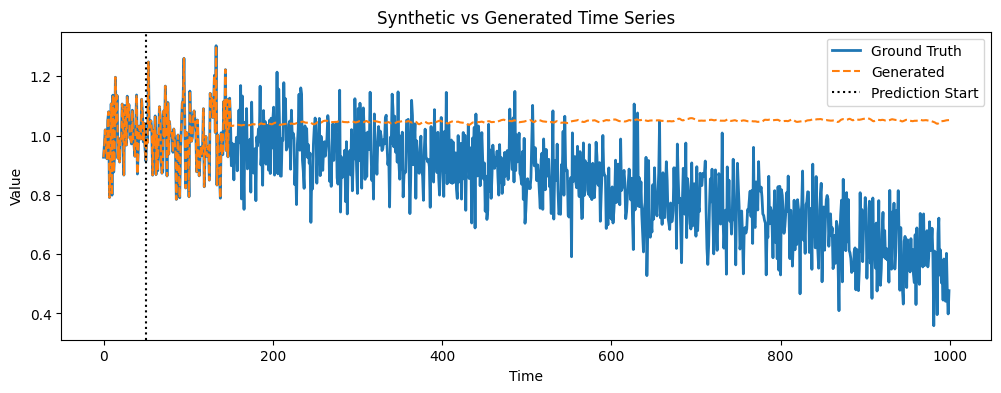

In [28]:
def generate_synthetic_data(n_samples=50, length=200):
    t = np.linspace(0, 5, length)
    data = []
    for _ in range(n_samples):
        phase = np.random.rand() * 2*np.pi
        freq = np.random.rand() * 0.5 + 0.1
        signal = np.sin(freq * t + phase) + 0.1*np.random.randn(length)
        data.append(signal)
    return data

samples = generate_synthetic_data(n_samples=100, length=1000)
processing = []
for sample in samples:
    processing.append(torch.tensor(sample, dtype=torch.float32))
train_samples = processing[:80]
val_samples = processing[80:]
model = TimeSeriesTransformer(1, D_M, 4, 3)
train_los, val_los, model = train(model, train_samples, val_samples, epochs=50)
model.eval()
signal = random.choice(val_samples)
signal = signal.unsqueeze(0).unsqueeze(-1)
generated = model.generate(signal[:, :150,:], 850)
signal_plot = signal.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(signal_plot, label="Ground Truth", linewidth=2)
plt.plot(generated_plot, label="Generated", linestyle="--")
gen_future = generated_plot[50:]

plt.axvline(50, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Estimation

In [49]:
def estimate_cp(signal, pen):
    return rpt.Pelt(model='rbf').fit(signal).predict(pen=pen)

In [50]:
def optimal_match_changepoints(true_times, pred_times, tol):
    n_true = len(true_times)
    n_pred = len(pred_times)

    cost = np.full((n_true, n_pred), fill_value=1e6)

    for i, t in enumerate(true_times):
        for j, p in enumerate(pred_times):
            if abs(t - p) <= tol:
                cost[i, j] = abs(t - p)

    row_ind, col_ind = linear_sum_assignment(cost)

    matches = cost[row_ind, col_ind] <= tol
    tp = np.sum(matches)

    fp = n_pred - tp
    fn = n_true - tp
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)

In [51]:
kernels = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12,
          gpflow.kernels.Matern32,
          gpflow.kernels.Matern52]

T = 5
xs, ys, arrival_times = sample_poisson_jumps(2, T, 3, length=1000)
noise = sample_dgp_signal(len(xs), 0, T, 1, kernels, 1)
noise = np.squeeze(noise)
signal = ys + noise
signals = [signal]
x, y = sequence_batch(signals, 50, 16)
print(x.shape)

ShapeMismatchError: 
Tensor shape mismatch.
  Function: Stationary.__init__
    Declared: C:\Users\motsk\anaconda3\envs\thesis\Lib\site-packages\gpflow\kernels\stationaries.py:38
    Argument: variance
      Expected: []
      Actual:   [1000, 1]
    Argument: lengthscales
      Expected: [broadcast n_active_dims]
      Actual:   []


10.0


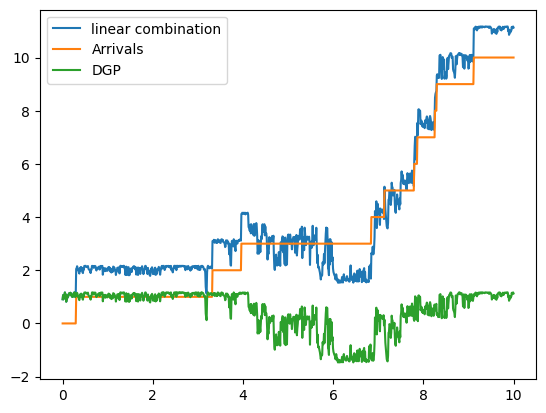

[30, 330, 565, 690, 750, 780, 825, 910, 1000]


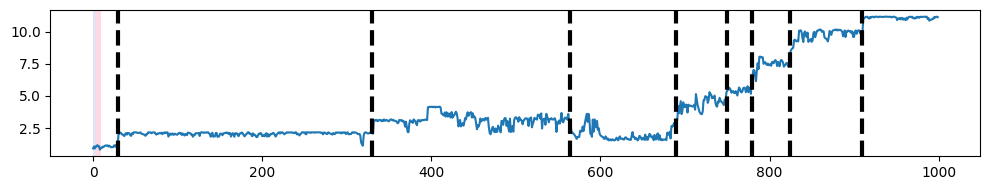

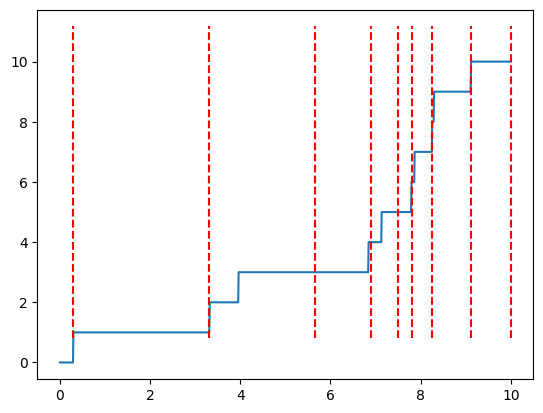

In [78]:
kernels = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12,
          gpflow.kernels.Matern32,
          gpflow.kernels.Matern52]



xs, ys, arrival_times, T = sample_poisson_jumps(2, 3, length=1000)
sample_kernels = randomly_sample_kernels(KERNELS, 3, seed=1)
noise = sample_dgp_signal(len(xs), 0, T, 1, sample_kernels, 3, seed=1)
noise = np.squeeze(noise)
signal = ys + noise
plt.plot(xs, signal, label = "linear combination")
plt.plot(xs, ys, label = "Arrivals")
plt.plot(xs, noise, label = "DGP")
plt.legend()
plt.show()
result1 = estimate_cp(signal, 10)
print(result1)
# display
rpt.display(signal, xs, result1)
plt.show()

plt.plot(xs, ys)
result1 = np.clip(result1, 0, len(signal)-1)
plt.vlines(xs[result1], ymin=signal.min(), ymax=signal.max(), color='red', linestyles='dashed')
plt.show()